# 时间序列分析步骤：
1. 绘制时序图，对时间序列初步分析
2. 对时序进行平滑化和季节性分解，前者能够去掉时序中的随机波动，使得时序图更平滑；后者能够判断出时序中是否存在季节性变化，也称为周期性变化，并且在做季节性分解时通常会展示出时序所包含的所有项。*时间序列包含的项有趋势项T，季节项S和随机项I，通常用乘法模型来描述这些变化比加法模型更合适。（在实际的代码中，可能无法直接使用乘法模型，此时应先对时序进行对数变换，最后再使用指数变换将时序还原）*  
3. 建立预测模型：  
  3.1 指数预测模型  
    （1）单指数模型：拟合的是只有常数水平项和时间点i处随机项的时间序列，即不存在趋势项和季节效应的时序；  
    （2）双指数模型：拟合的是有水平项和趋势项的时序；  
    （3）三指数模型：拟合的是有水平项、趋势项以及季节效应的时序；  
  3.2 ARIMA预测模型  
    *注意此模型一般是在非季节性时序上建立的*  
    （1）确保时序是平稳的（使用ADF检验，注意此检验的原假设为时序是非平稳的，若拒绝原假设，得到的结论是此时序为平稳序列，可以继续讨论）  
    （2）若时序是非平稳的，则需要通过差分处理，可以进行一阶差分、二阶差分，最后时序通过了ADF检验即可  
    （3）绘制自相关图和偏自相关图：根据其拖尾情况来选择p和q的大小（p和q为模型的阶数）  
    （4）拟合模型（还有一种自动预测模型的方法，可以不绘制自相关图和偏自相关图，但是这样的方法不一定准确）  
    （5）模型评价：  
       a. 检验残差的自相关系数是否为零，好的模型的残差应当不通过显著性检验，即不拒绝原假设（原假设是残差的自相关系数为零），可以认为残差的自相关系数为零。  
       b. AIC信息准则：即AIC值越小，模型越好，其公式为(2k-2L)/n，k是所拟合模型中参数的数量，L是对数似然值,n是观测值数目。k小意味着模型简洁，L大意味着模型精确。因此在评价模型是兼顾了简洁性和精确性。  
       c. 准确性度量：MPE（平均绝对误差）和MAPE（平均绝对百分比误差），误差越小，模型越准确
    （6）预测：使用建立好的模型预测之后时间点上的数据  
**本案例是基于俄乌战争，分析对大宗商品股票价格的影响；之前看过老师发的公众号文章，里面提到过使用时间序列模型来预测新冠疫情，后续会关注一些这方面的文章**

一.导入库

In [28]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, 
                                         SimpleExpSmoothing,Holt)
import seaborn as sns

二、数据准备

In [29]:
data = pd.read_excel('E:/postgraduate/案例选题数据及说明/美小麦连续1.xlsx')

In [30]:
data['时间'] = data['时间'].str.split(',').str[0]
data.index = data['时间']
data = data[['开盘','最高','最低','收盘','总手']]
data.head()

,开盘,最高,最低,收盘,总手
时间,,,,,
2021-01-12,636.25,670.00,634.00,664.75,76800
2021-01-13,665.00,680.75,656.25,659.25,76421
2021-01-14,660.00,673.25,653.00,670.50,57699
2021-01-15,671.00,693.00,664.50,674.75,75385
2021-01-19,683.75,691.25,668.75,673.25,61713


In [31]:
data1 = data.loc['2021-01-12':'2022-02-23']#取2022-2-24之前的数据
data1.tail()

,开盘,最高,最低,收盘,总手
时间,,,,,
2022-02-16,779.75,786.75,773.25,779.00,30459
2022-02-17,780.00,799.25,775.50,796.75,39362
2022-02-18,797.50,812.25,790.00,793.75,37767
2022-02-22,815.00,846.25,803.00,839.75,44590
2022-02-23,841.00,880.00,834.00,874.50,26272


为了分析俄乌战争对小麦股票价格的影响，我们对2021-01-12到2022-02-24的数据建立时间序列模型，并预测之后的数据，与实际的数据进行比较，进而可分析战争的影响。

Text(0, 0.5, '收盘价')

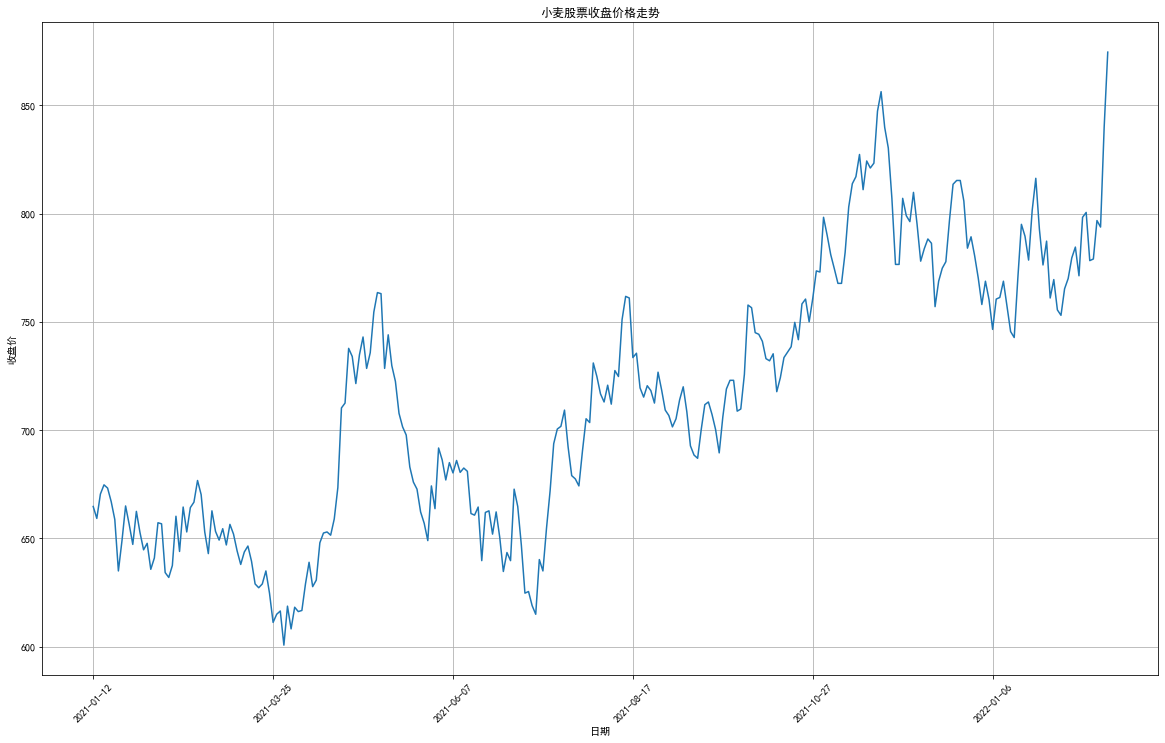

In [53]:
#绘制时序图
ts = data1['收盘']
plt.rcParams['font.sans-serif'] = ['simhei']  #用来正常显示中文标签 
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号 
ts.plot(figsize=(20,12))         
plt.title("小麦股票收盘价格走势")  #添加图标题 
plt.xticks(rotation=45)  #横坐标旋转45度
plt.grid()
plt.xlabel('日期')   #添加图的标签（x轴，y轴）
plt.ylabel('收盘价')

<ipython-input-62-7e091852af6b>:9: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead.
  decomposition = seasonal_decompose(ts,model='multiplicative', freq=30)


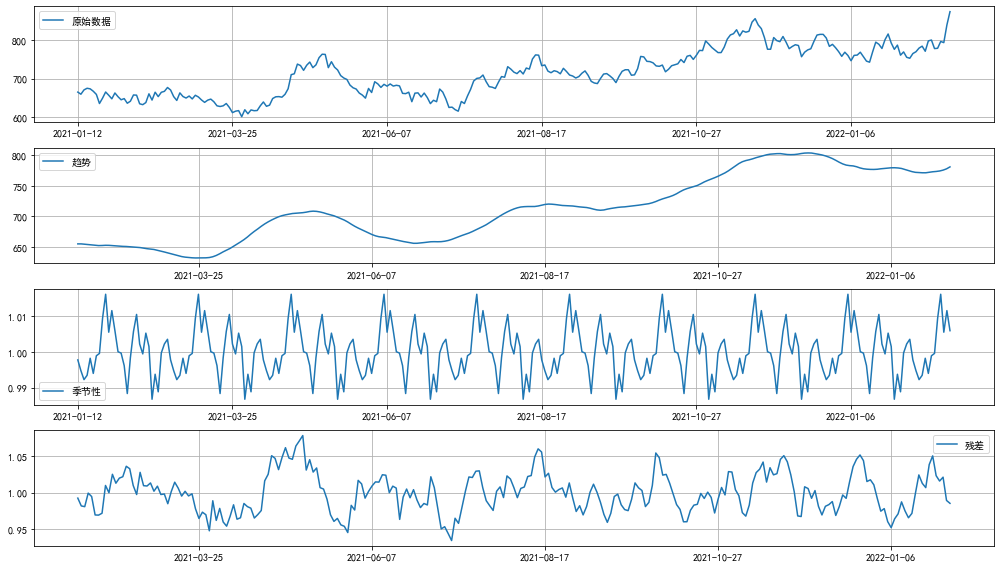

In [62]:

rcParams['figure.figsize'] = 14, 8
#result = seasonal_decompose(ts, model='multiplicative', freq=30)
#plt.figure(figsize=(16,8))
#fig = result.plot()
#plt.grid()
#plt.show()


decomposition = seasonal_decompose(ts,model='multiplicative', freq=30)
trend = decomposition.trend #趋势效应
seasonal = decomposition.seasonal #季节效应
residual = decomposition.resid #随机效应
ax = plt.subplot(411)
ax.grid()
ax.plot(ts, label=u'原始数据')
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
plt.legend(loc='best')
ax = plt.subplot(412)
ax.grid()
ax.plot(trend, label=u'趋势')
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
plt.legend(loc='best')
ax = plt.subplot(413)
ax.grid()
ax.plot(seasonal,label=u'季节性')
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
plt.legend(loc='best')
ax = plt.subplot(414)
ax.grid()
ax.plot(residual, label=u'残差')
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
plt.legend(loc='best')
plt.tight_layout()

由此图可判断出原来的时间序列含有趋势项、季节项、以及常数项

In [73]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    rollmean = timeseries.rolling(8).mean()
    rollstd  = timeseries.rolling(8).std()
    
    # plot rolling stats
    ax = plt.subplot(111)
    orig = plt.plot(timeseries, color = 'red', label = '原始序列')
    mean = plt.plot(rollmean, color='green', label = '移动平均')
    std  = plt.plot(rollstd, color = 'blue', label = '移动标准差')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
    plt.legend(loc = 'best')
    plt.title('移动平均和标准差')
    plt.grid()
    plt.show(block = False)
    
    # DF test for stationarity
    print('Dickey-Fuller test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['t-stat','p-val', '#lags used','no. of obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

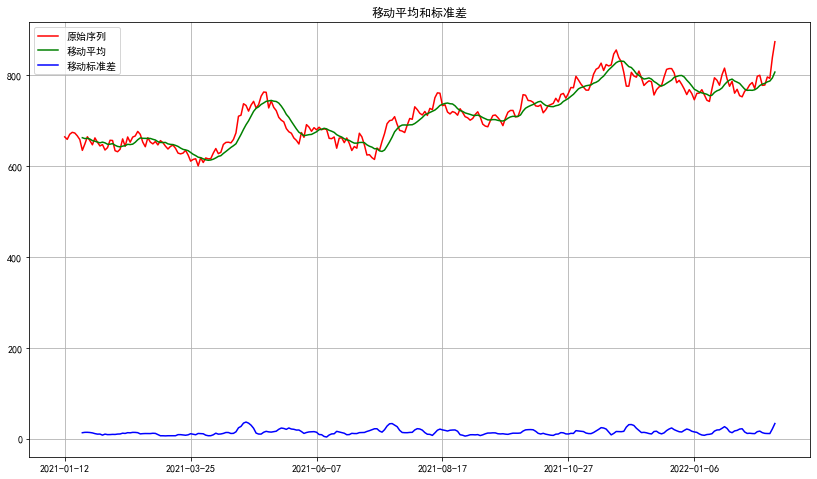

Dickey-Fuller test:
t-stat                   -0.980560
p-val                     0.760288
#lags used                0.000000
no. of obs              282.000000
Critical Value (1%)      -3.453754
Critical Value (5%)      -2.871844
Critical Value (10%)     -2.572261
dtype: float64


In [74]:
test_stationarity(ts)

由上图移动平均的平均值和标准差可以看出，时间序列的平均值会随着时间变化，是有趋势效应的，标准差可认为是不变的；t值比1%、5%、10%的都小，并且p值很大，所以无法拒绝原假设，认为该序列为不平稳的时间序列。

可以看出时间序列不平稳，因此我们要将时间序列转为平稳序列。  
**如何理解时间序列的平稳性**  
我们使用时间序列来预测未来的数据，其前提是过去的时间序列的本质特征能够延续到未来，常用均值、方差、协方差来刻画其本质特征，如果这些统计量的取值在未来仍能保持不变，则说明该序列具有平稳性。白噪声是平稳的，但是其序列是完全随机的，无法用来预测未来的数据。因此在确定一个序列是平稳的之后，还需要做白噪声检验，来判断其是否不是一个白噪声，若不是则能够在此时间序列上建立模型。

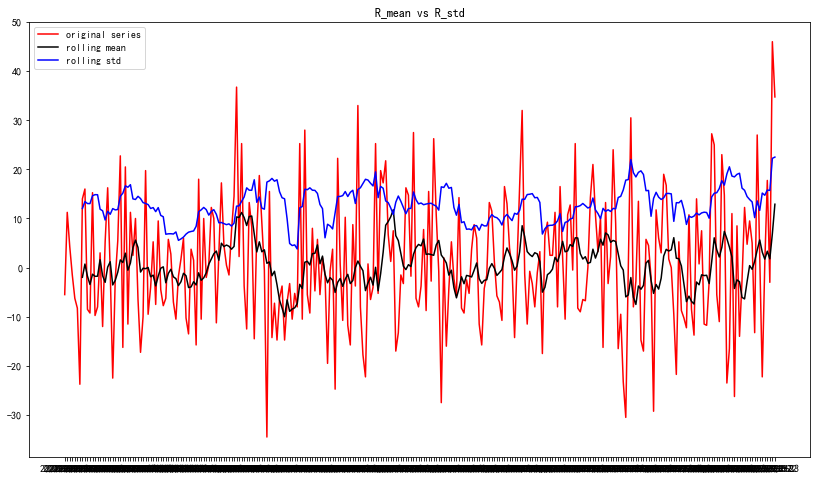

Dickey-Fuller test:
t-stat                 -1.623668e+01
p-val                   3.763681e-29
#lags used              0.000000e+00
no. of obs              2.810000e+02
Critical Value (1%)    -3.453838e+00
Critical Value (5%)    -2.871881e+00
Critical Value (10%)   -2.572280e+00
dtype: float64


In [45]:
ts_diff1 = ts.diff(1).dropna()#通过一阶差分消除趋势项
test_stationarity(ts_diff1)#判断一阶差分后的序列是否平稳

由ADF检验的结果可知，经过差分的时间序列为平稳序列。下面判断其是否为白噪声

In [48]:
r,q,p = sm.tsa.acf(ts_diff1.values.squeeze(), qstat=True) 
data = np.c_[range(1,41), r[1:], q, p] 
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"]) 
print(table.set_index('lag'))

            AC          Q  Prob(>Q)
lag                                
1.0   0.016513   0.077713  0.780422
2.0  -0.047907   0.734159  0.692755
3.0   0.023338   0.890509  0.827717
4.0  -0.083511   2.899631  0.574760
5.0  -0.103364   5.988718  0.307318
6.0   0.086180   8.143823  0.227755
7.0  -0.022569   8.292157  0.307538
8.0   0.027014   8.505463  0.385713
9.0   0.023110   8.662146  0.469027
10.0  0.051665   9.448082  0.490171
11.0 -0.029890   9.712115  0.556453
12.0 -0.030212   9.982854  0.617465
13.0 -0.010280  10.014320  0.692763
14.0 -0.003865  10.018783  0.760809
15.0 -0.015070  10.086906  0.814238
16.0 -0.086730  12.351684  0.719437
17.0 -0.032011  12.661376  0.758543
18.0 -0.029055  12.917481  0.796452
19.0 -0.022177  13.067243  0.835111
20.0  0.021592  13.209752  0.868204
21.0  0.089174  15.649826  0.788992
22.0 -0.045037  16.274613  0.802027
23.0 -0.006845  16.289101  0.842616
24.0 -0.010482  16.323206  0.876058
25.0 -0.002017  16.324473  0.904823
26.0 -0.092886  19.023615  0

F:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
F:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


<ipython-input-73-768eca1333fc>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


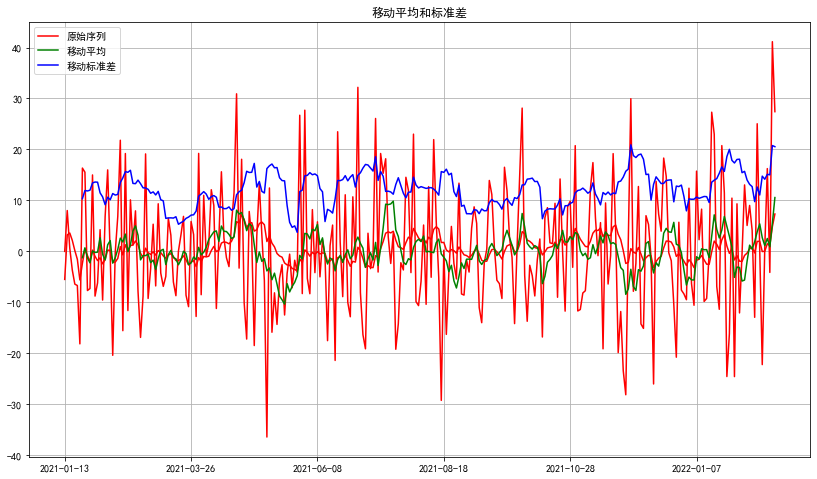

Dickey-Fuller test:
t-stat                 -9.087734e+00
p-val                   3.898859e-15
#lags used              4.000000e+00
no. of obs              2.770000e+02
Critical Value (1%)    -3.454180e+00
Critical Value (5%)    -2.872031e+00
Critical Value (10%)   -2.572360e+00
dtype: float64


In [75]:
#一阶差分后再做季节差分
expwighted_avg = ts_diff1.ewm(halflife=8).mean() # 指数加权的移动窗口函数
#plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')    
ts_ewma_diff = ts_diff1 - expwighted_avg
test_stationarity(ts_ewma_diff)

In [50]:
r,q,p = sm.tsa.acf(ts_ewma_diff.values.squeeze(), qstat=True) 
data = np.c_[range(1,41), r[1:], q, p] 
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"]) 
print(table.set_index('lag'))

            AC          Q  Prob(>Q)
lag                                
1.0  -0.012793   0.046642  0.829012
2.0  -0.069518   1.428932  0.489453
3.0   0.005328   1.437080  0.696866
4.0  -0.101819   4.423698  0.351691
5.0  -0.120165   8.598545  0.126189
6.0   0.070870  10.055970  0.122315
7.0  -0.034689  10.406409  0.166688
8.0   0.023490  10.567696  0.227417
9.0   0.014460  10.629036  0.301996
10.0  0.046987  11.279094  0.336191
11.0 -0.029679  11.539408  0.399240
12.0 -0.031518  11.834072  0.459096
13.0 -0.009678  11.861955  0.538995
14.0  0.000029  11.861956  0.617388
15.0 -0.014163  11.922124  0.684914
16.0 -0.082873  13.989941  0.599463
17.0 -0.027530  14.218985  0.651545
18.0 -0.023968  14.393259  0.703119
19.0 -0.024250  14.572329  0.749364
20.0  0.020744  14.703863  0.793094
21.0  0.094823  17.462859  0.682696
22.0 -0.037377  17.893185  0.712302
23.0 -0.005804  17.903603  0.762697
24.0 -0.005968  17.914658  0.807129
25.0  0.003760  17.919063  0.845807
26.0 -0.082042  20.024798  0

F:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
F:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


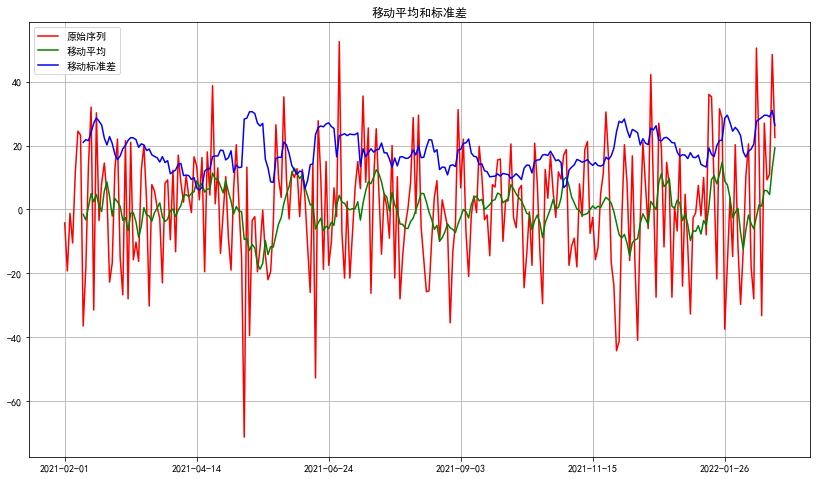

Dickey-Fuller test:
t-stat                 -7.076675e+00
p-val                   4.782113e-10
#lags used              1.100000e+01
no. of obs              2.580000e+02
Critical Value (1%)    -3.455953e+00
Critical Value (5%)    -2.872809e+00
Critical Value (10%)   -2.572775e+00
dtype: float64


In [81]:
ts_first_difference = ts - ts.shift(1) #一阶差分
ts_seasonal_first_difference = ts_first_difference - ts_first_difference.shift(12) #12步差分  
test_stationarity(ts_seasonal_first_difference.dropna(inplace=False))

In [82]:
ts_seasonal_first_difference.dropna(inplace = True)
r,q,p = sm.tsa.acf(ts_seasonal_first_difference.values.squeeze(), qstat=True) 
data = np.c_[range(1,41), r[1:], q, p] 
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"]) 
print(table.set_index('lag'))

            AC          Q      Prob(>Q)
lag                                    
1.0   0.029798   0.242416  6.224663e-01
2.0  -0.056370   1.113167  5.731638e-01
3.0   0.010537   1.143706  7.665351e-01
4.0  -0.052007   1.890461  7.558972e-01
5.0  -0.059837   2.882707  7.180630e-01
6.0   0.055073   3.726445  7.136384e-01
7.0   0.030734   3.990216  7.809037e-01
8.0   0.062652   5.090487  7.478624e-01
9.0  -0.030627   5.354419  8.023833e-01
10.0  0.074588   6.925878  7.324235e-01
11.0 -0.031865   7.213790  7.815155e-01
12.0 -0.457637  66.828874  1.249377e-09
13.0 -0.009016  66.852103  3.032157e-09
14.0  0.036408  67.232368  6.093659e-09
15.0 -0.012747  67.279166  1.357204e-08
16.0 -0.011565  67.317839  2.929117e-08
17.0  0.043365  67.863704  5.013907e-08
18.0 -0.090215  70.235580  4.122823e-08
19.0  0.010190  70.265963  8.307394e-08
20.0  0.015010  70.332150  1.607417e-07
21.0  0.048068  71.013626  2.414998e-07
22.0 -0.049162  71.729331  3.525143e-07
23.0  0.020936  71.859655  6.257408e-07


F:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
F:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [83]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(ts_seasonal_first_difference, lags = [6, 12],boxpierce=True)

F:\anaconda\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([ 3.72644503, 66.82887382]),
 array([7.13638367e-01, 1.24937709e-09]),
 array([ 3.64358068, 63.53464389]),
 array([7.24779191e-01, 5.08087865e-09]))

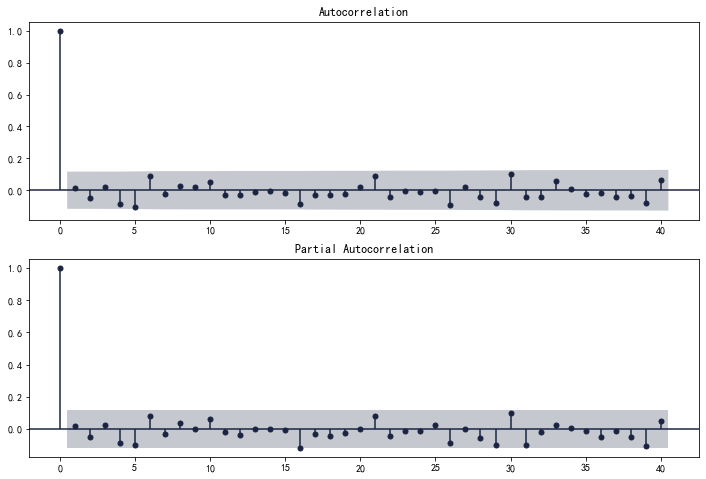

In [82]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff1, lags=40, ax=ax1) #从13开始是因为做季节性差分时window是12
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff1, lags=40, ax=ax2)

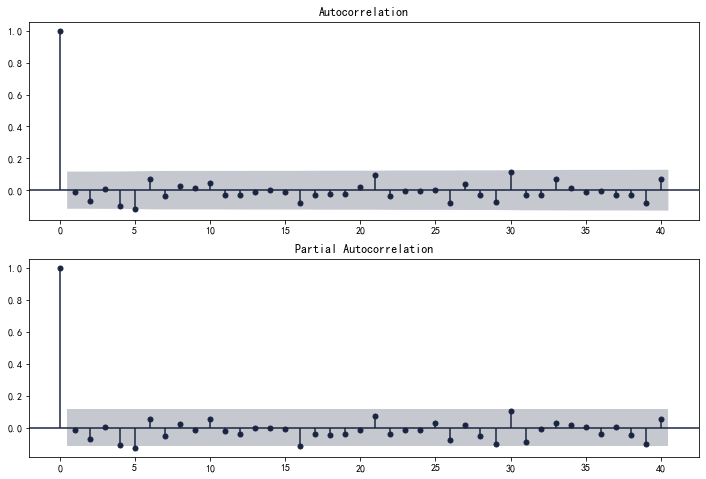

In [175]:
fig = plt.figure(figsize=(12,8))
ax3 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_ewma_diff, lags=40, ax=ax3) 
ax4 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_ewma_diff, lags=40, ax=ax4)

In [17]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(ts, trend='n', order=(0,1,0), seasonal_order=(0,2,2,12))
results = mod.fit()
print(results.summary())

F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                        SARIMAX Results                                        
Dep. Variable:                                      收盘   No. Observations:                  283
Model:             SARIMAX(0, 1, 0)x(0, 2, [1, 2], 12)   Log Likelihood               -1098.728
Date:                                 Fri, 11 Mar 2022   AIC                           2203.456
Time:                                         10:29:04   BIC                           2214.115
Sample:                                              0   HQIC                          2207.742
                                                 - 283                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -1.7366      0.068    -25.621      0.000      -1.869      -1

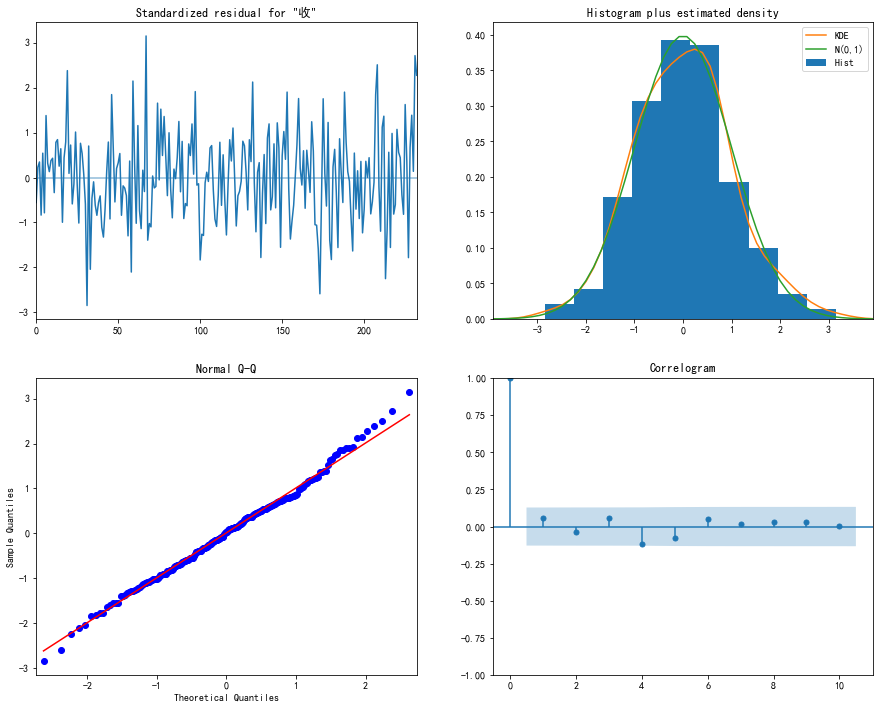

In [86]:
# 模型诊断
results.plot_diagnostics(figsize=(15, 12))
plt.show()
# LB检验
#r, q, p = sm.tsa.acf(results.residual.values.squeeze(), qstat=True)
#data = np.c_[range(1, 41), r[1:], q, p]
#table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
#print(table.set_index('lag'))

Ljung-Box q 统计量用于检验某个时间段内的一系列观测值是不是随机的独立观测值。如果观测值并非彼此独立，一个观测值可能会在 k 个时间单位后与另一个观测值相关，形成一种称为自相关的关系。由上面结果可知，其p值为0.92，不应拒绝原假设，因此可认为模型的残差不具有自相关性，是一组白噪声，证明模型良好。
由上图可知，模型的残差服从正态分布，且除了第一个点之外其他点不具有自相关性，因此可认为残差是一个白噪声，模型的拟合效果良好。

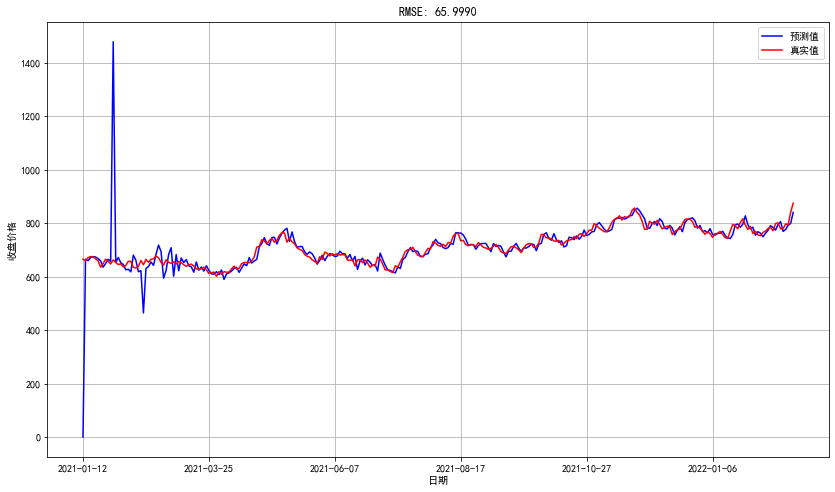

In [115]:
#静态预测
predict_ts = results.predict()
predict_ts.plot(color='blue', label='预测值')
ts.plot(color='red', label='真实值')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((predict_ts-ts)**2)/ts.size))
#RMSE = np.sqrt(sum((predict_ts-ts)**2)/ts.size
plt.xlabel('日期')
plt.ylabel('收盘价格')
plt.grid()
plt.show()

静态预测刚开始的效果不太好，之后的效果很不错。均方根误差RMSE为58.2754，下面计算预测的准确率。

In [116]:
pre = results.forecast(12)
print(pre)

F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


283    872.340855
284    876.960700
285    887.052798
286    883.080914
287    891.927943
288    890.126901
289    888.026491
290    880.247492
291    882.113172
292    877.113095
293    893.320591
294    903.109176
Name: predicted_mean, dtype: float64


<Figure size 2160x720 with 0 Axes>

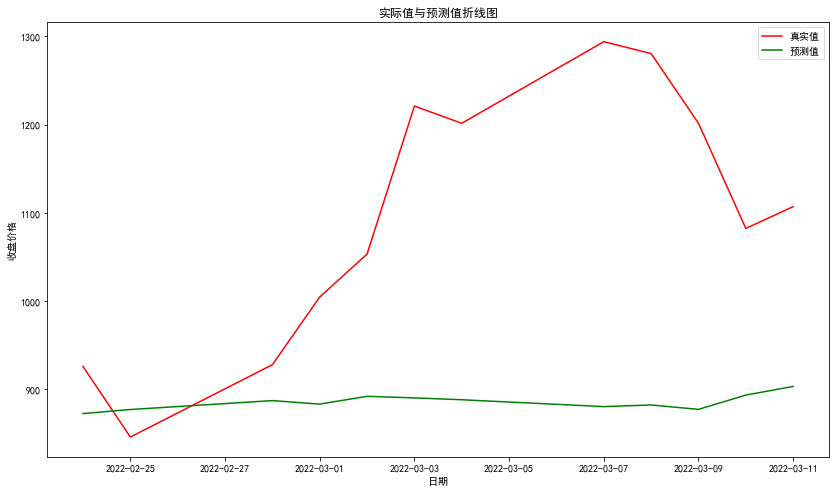

In [123]:
import matplotlib.ticker as ticker
data3 = pd.read_excel('E:/postgraduate/案例选题数据及说明/小麦.xlsx')
#data3['时间'] = data3['时间'].str.split(',').str[0]

data3 = data3[['日期','真实值','预测值']]
plt.figure(figsize=(30,10))

x = data3['日期']
y1 = data3['真实值']
y2 = data3['预测值']
fig, ax = plt.subplots(1,1)
ax.plot(x,y1,color = 'r',label = '真实值')

#ax.xaxis.set_major_locator(ticker.MultipleLocator(base=20))

plt.plot(x,y2,color = 'g',label = '预测值')
plt.xlabel('日期')
plt.ylabel('收盘价格')
plt.title('实际值与预测值折线图')

plt.legend()
plt.show()

In [107]:
y1 = data3.iloc[-8:-1,3:4]


0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
285    887.03
286    883.04
287    891.90
288    890.13
289    888.03
Name: 预测, Length: 290, dtype: float64

In [134]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
from statsmodels.tsa.arima_model import ARIMA 
 
pmax = int(5)    #一般阶数不超过 length /10
qmax = int(5)
bic_matrix = []
for p in range(pmax +1):
    temp= []
    for q in range(qmax+1):
        try:
            temp.append(ARIMA(ts, (p, 1, q)).fit().bic)
        except:
            temp.append(None)
        bic_matrix.append(temp)

bic_matrix = pd.DataFrame(bic_matrix)   #将其转换成Dataframe 数据结构
p,q = bic_matrix.stack().astype('float64').idxmin()   #先使用stack 展平， 然后使用 idxmin 找出最小值的位置
print(u'BIC 最小的p值 和 q 值：%s,%s' %(p,q))  #  BIC 最小的p值 和 q 值：0,1


BIC 最小的p值 和 q 值：0,0


In [176]:
import itertools
def get_ARIMA_params(data, pdq, m=12):
    p = d = q = range(0, 3)
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]
    score_aic = 1000000.0
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(data,
                                        order=pdq,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))
        if results.aic < score_aic:
            score_aic = results.aic
            params = param_seasonal, results.aic
    param_seasonal, results.aic = params
    print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))



In [177]:
pdq = [0, 1, 0]
get_ARIMA_params(ts, pdq)

x(0, 0, 0, 12)12 - AIC:2254.789473536411
x(0, 0, 1, 12)12 - AIC:2162.6663846479464
x(0, 0, 2, 12)12 - AIC:2067.5570428421565
x(0, 1, 0, 12)12 - AIC:2345.7798809240585
x(0, 1, 1, 12)12 - AIC:2091.6578158230095
x(0, 1, 2, 12)12 - AIC:2005.415154872664
x(0, 2, 0, 12)12 - AIC:2512.513530900639
x(0, 2, 1, 12)12 - AIC:2163.141344241193
x(0, 2, 2, 12)12 - AIC:1965.9248100822397
x(1, 0, 0, 12)12 - AIC:2169.9916172344256
x(1, 0, 1, 12)12 - AIC:2161.3646367027973
x(1, 0, 2, 12)12 - AIC:2069.554542905209
x(1, 1, 0, 12)12 - AIC:2173.9926523125605
x(1, 1, 1, 12)12 - AIC:2093.6578197986146
x(1, 1, 2, 12)12 - AIC:2004.3430209260814
x(1, 2, 0, 12)12 - AIC:2271.492445154779
x(1, 2, 1, 12)12 - AIC:2111.6039274138066
x(1, 2, 2, 12)12 - AIC:1968.0145230044209
x(2, 0, 0, 12)12 - AIC:2077.1319962873376
x(2, 0, 1, 12)12 - AIC:2079.0451269350215
x(2, 0, 2, 12)12 - AIC:2070.4972691504518
x(2, 1, 0, 12)12 - AIC:2050.125517279292
x(2, 1, 1, 12)12 - AIC:2015.3077756935222
x(2, 1, 2, 12)12 - AIC:2006.3327668015881

建立指数预测模型，并且选择的是三指数模型

In [18]:
#准备训练集和测试集的数据
train = ts.loc['2021-01-12':'2021-12-31']
test = ts.loc['2021-12-31':'2022-02-23']
test_length = len(test)

In [19]:
SEASONAL_PERIODS = 12
 
 
# Holt-Winter's model with exponential trend
hw_1 = ExponentialSmoothing(train, 
                            trend='mul', 
                            seasonal='add', 
                            seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(test_length)
# Holt-Winter's model with exponential trend and damping
hw_2 = ExponentialSmoothing(train, 
                            trend='mul', 
                            seasonal='add', 
                            seasonal_periods=SEASONAL_PERIODS, 
                            damped=True).fit()
hw_forecast_2 = hw_2.forecast(test_length)

F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
F:\anaconda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
F:\anaconda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
<ipython-input-19-fdec5f1921fc>:11: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  hw_2 = ExponentialSmoothing(train,
F:\anaconda\lib\site-package

KeyError: 'damping_slope'

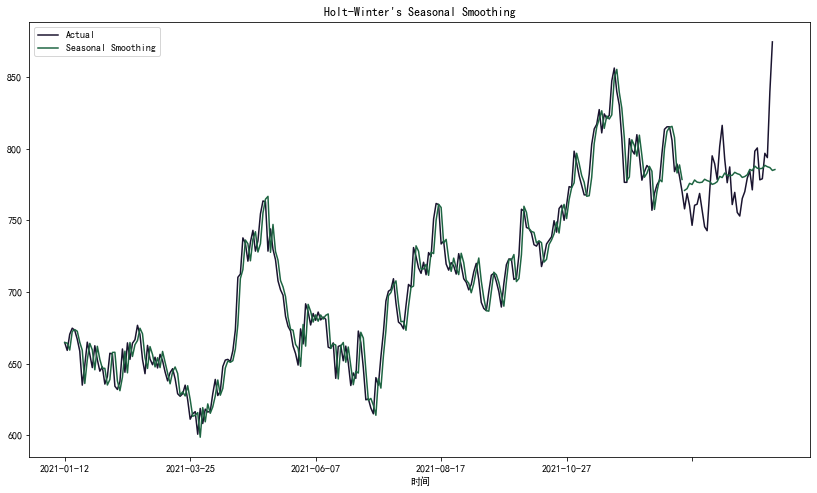

In [24]:
#绘制结果

plt.set_cmap('cubehelix')
sns.set_palette('cubehelix')

COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]
ts.plot(color=COLORS[0],
          title="Holt-Winter's Seasonal Smoothing",
          label='Actual',
          legend=True)
 
hw_1.fittedvalues.plot(color=COLORS[1])
hw_forecast_1.plot(color=COLORS[1], legend=True, 
                   label='Seasonal Smoothing')
 
phi = hw_2.model.params['damping_slope']
plot_label = f'Seasonal Smoothing (damped with $\phi={phi:.4f}$)'
 
hw_2.fittedvalues.plot(color=COLORS[2])
hw_forecast_2.plot(color=COLORS[2], legend=True, 
                   label=plot_label)
 
plt.tight_layout()
#plt.savefig('images/ch3_im17.png')
plt.show()

由于使用三次指数平滑建立预测模型在测试集上的效果不好，下面先使用指数平滑的方法去掉趋势项和季节项，再对剩下的平稳序列建立ARIMA模型。

In [105]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    rollmean = timeseries.rolling(8).mean()
    rollstd  = timeseries.rolling(8).std()
    
    # plot rolling stats
    
    orig = plt.plot(timeseries, color = 'red', label = 'original series')
    mean = plt.plot(rollmean, color='black', label = 'rolling mean')
    std  = plt.plot(rollstd, color = 'blue', label = 'rolling std')
    plt.legend(loc = 'best')
    plt.title('R_mean vs R_std')
    plt.show(block = False)
    
    # DF test for stationarity
    print('Dickey-Fuller test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['t-stat','p-val', '#lags used','no. of obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


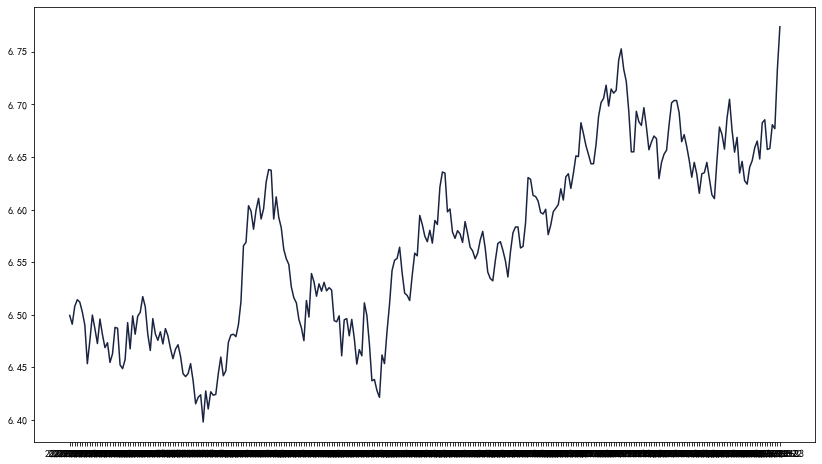

In [106]:
#对原始的时间序列取对数，则在此基础上的加法模型，相当于是对原始序列的乘法模型
ts_log = np.log(ts)
plt.plot(ts_log)

去除序列中的随机扰动，以便对事件序列进行平滑处理

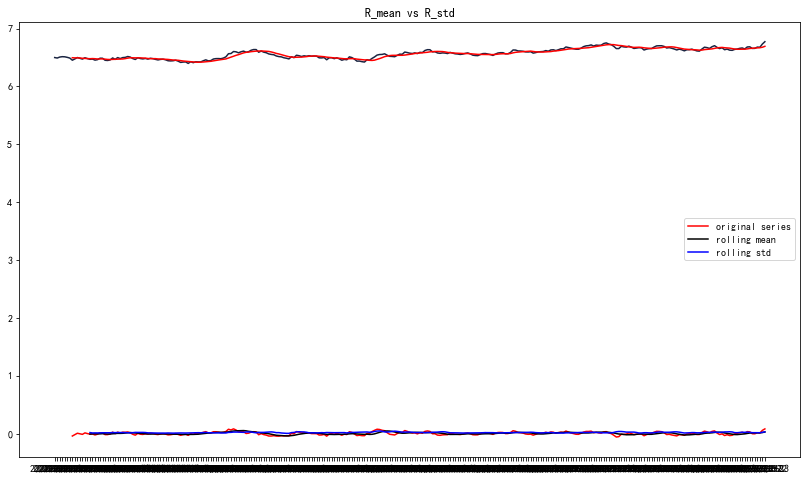

Dickey-Fuller test:
t-stat                 -6.220436e+00
p-val                   5.239411e-08
#lags used              3.000000e+00
no. of obs              2.720000e+02
Critical Value (1%)    -3.454622e+00
Critical Value (5%)    -2.872225e+00
Critical Value (10%)   -2.572464e+00
dtype: float64


In [107]:
moving_avg = ts_log.rolling(8).mean()#rolling函数是用来做移动运算的
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(8)

ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)


可以看出p值非常小，并且接近于零，因此应当拒绝原假设（原假设为不平稳），认为去掉噪音后的时序是平稳的。  
下面对时序进行指数平滑去掉季节项

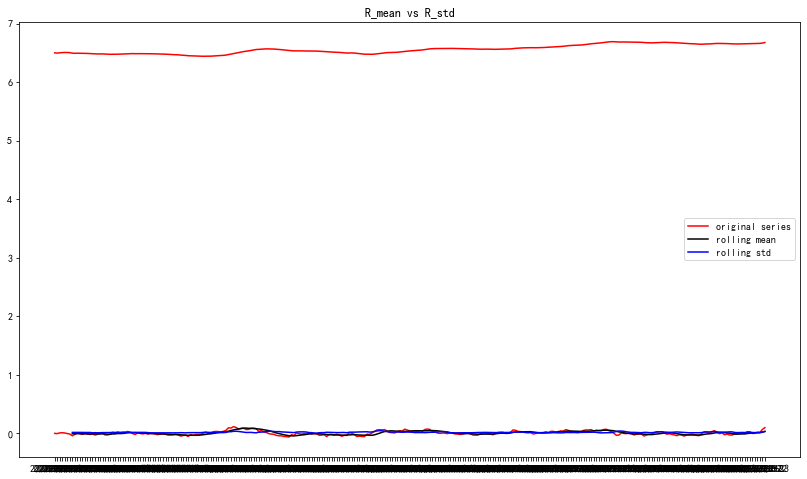

Dickey-Fuller test:
t-stat                   -4.010570
p-val                     0.001356
#lags used                0.000000
no. of obs              282.000000
Critical Value (1%)      -3.453754
Critical Value (5%)      -2.871844
Critical Value (10%)     -2.572261
dtype: float64


In [108]:

expwighted_avg = ts_log.ewm(halflife=8).mean() # 指数加权的移动窗口函数
#plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')    

ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)


p值十分接近于零，证明指数平滑后的时间序列仍然是一个平稳的时间序列。  
t值比临界值小的不多，因此可以做一阶差分后得到更好的结果

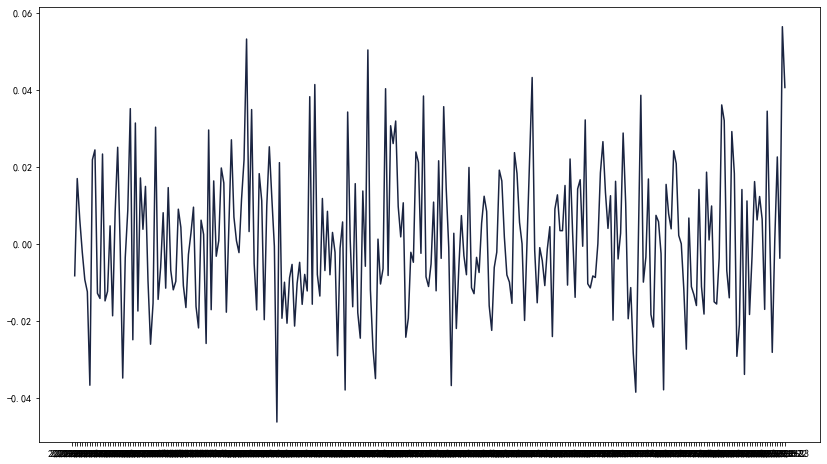

In [109]:
ts_log_diff = ts_log - ts_log.shift()  #  first order differencing 
plt.plot(ts_log_diff)

#ts_log_diff.dropna(inplace=True)
#test_stationarity(ts_log_diff)

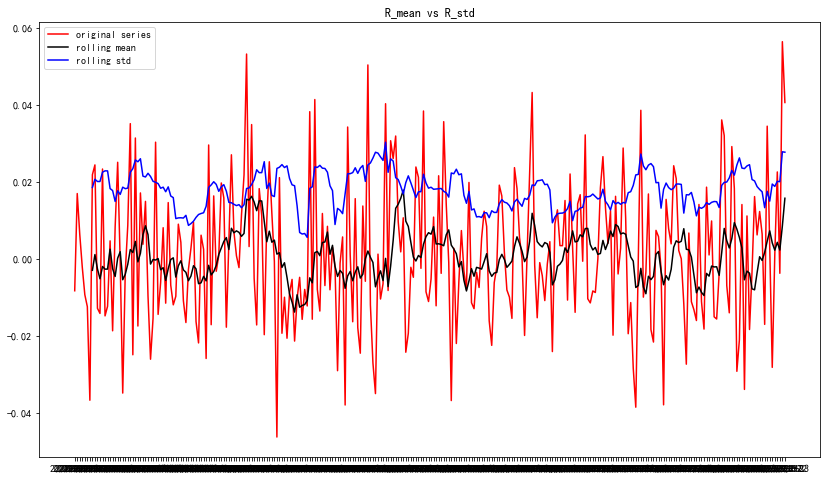

Dickey-Fuller test:
t-stat                 -1.666703e+01
p-val                   1.556500e-29
#lags used              0.000000e+00
no. of obs              2.810000e+02
Critical Value (1%)    -3.453838e+00
Critical Value (5%)    -2.871881e+00
Critical Value (10%)   -2.572280e+00
dtype: float64


In [110]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

一阶差分后的时间序列t值远小于临界值，因此我们使用一阶差分后的时序。  
下面进行季节性分解

<ipython-input-111-23bd4d8ab563>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead.
  decomposition = seasonal_decompose(ts_log, freq = 100)


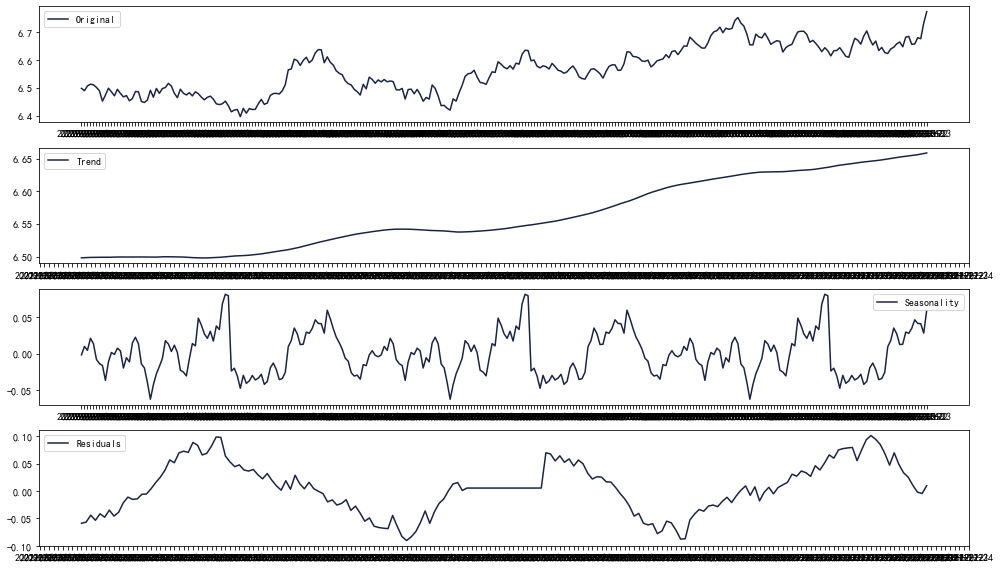

In [111]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, freq = 100)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

由上图可看到季节项、趋势项和随机项被分别绘制成了不同的图像，下面检查随机项的平稳性

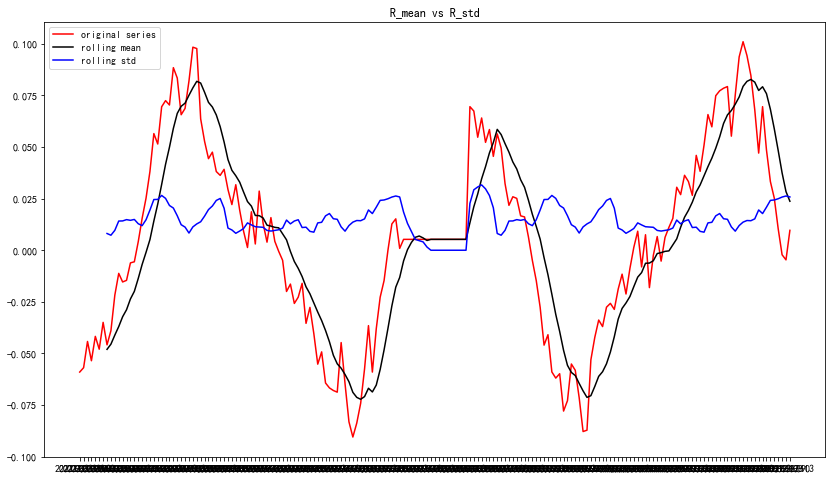

Dickey-Fuller test:
t-stat                   -3.522751
p-val                     0.007422
#lags used                7.000000
no. of obs              175.000000
Critical Value (1%)      -3.468280
Critical Value (5%)      -2.878202
Critical Value (10%)     -2.575653
dtype: float64


In [112]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

由p值可知，随机项是平稳的。  
下面绘制自相关图和偏自相关图

F:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


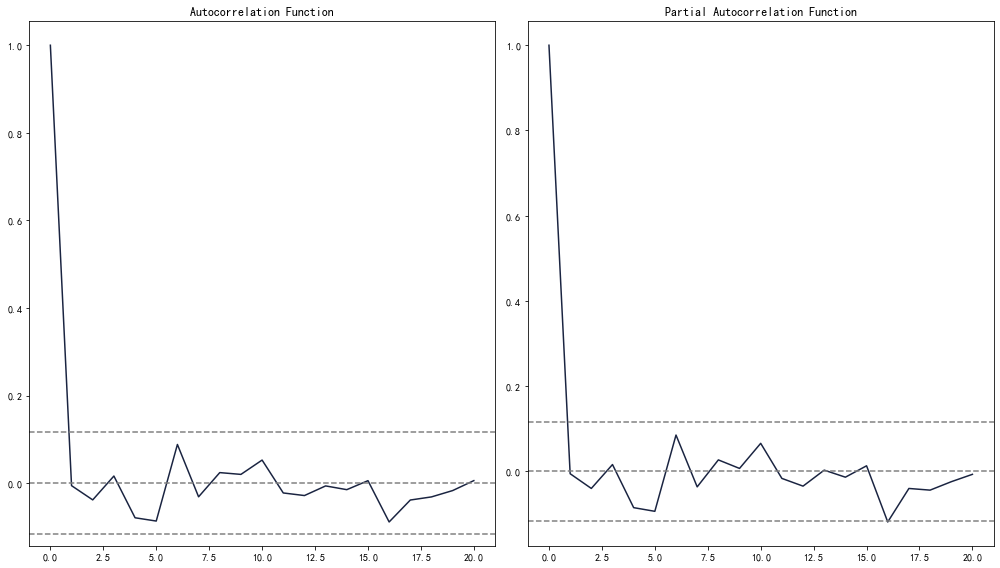

In [113]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')  # ordinary least square estimation


#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [121]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log_diff, order=(1, 0, 0))  
results_AR = model.fit()  
print(results_AR.summary())

F:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will b

AttributeError: 'pandas._libs.properties.CachedProperty' object has no attribute 'func'